In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive

In [ ]:
# Veri yolu
drive.mount('/content/drive')
# Datasetin bulunduğu yolu belirleyelim
dataset_path = "/content/drive/MyDrive/dataset"
# Train, Validation ve Test dizinlerini oluştur
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")
# Parametreler
img_size = (224, 224)  # Görsellerin boyutu
batch_size = 512  # Batch boyutu
num_classes = 3  # Sınıf sayısı
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)
val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 6739 files belonging to 3 classes.
Found 1685 files belonging to 3 classes.
Found 2106 files belonging to 3 classes.


In [ ]:
# Model oluşturma fonksiyonu
def create_resnet101_model(img_size, num_classes):
    # ResNet101 temel modelini yükle (ağırlıkları ImageNet ile önceden eğitilmiş)
    base_model = ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )

    # ResNet101 katmanlarını dondur (transfer öğrenme için)
    for layer in base_model.layers:
        layer.trainable = False

    # Sınıflandırma başlığı ekle
    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = preprocess_input(inputs)  # ResNet için ön işleme
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)  # Overfitting'i azaltmak için dropout
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Modeli derle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Görselleştirme için fonksiyon
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Doğruluk grafiği
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss grafiği
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Confusion Matrix için fonksiyon
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Sınıf isimlerini eğitim veri setinden al (önbellekleme ve önyükleme yapmadan önce)
class_names = train_ds.class_names
print(f"Sınıflar: {class_names}")

Sınıflar: ['glass', 'paper', 'plastic']


In [ ]:
# Veri ön işleme
# AUTOTUNE parametresi performans için
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Erken durdurma için callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Öğrenme oranını azaltma için callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,        # Öğrenme oranını 0.2 faktörü ile azalt
    patience=5,        # 3 epoch boyunca iyileşme olmazsa
    min_lr=0.00001,    # Minimum öğrenme oranı
    verbose=1          # Değişiklikleri ekrana yazdır
)

In [ ]:
# ResNet101 modelini oluştur
model = create_resnet101_model(img_size, num_classes)
print("Model oluşturuldu.")

# Model mimarisini özetle
model.summary()

Model oluşturuldu.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet101           │ (None, 7, 7,      │ 42,658,176 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet101[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │      1,539 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,708,803 (166.74 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [ ]:
# Modeli eğit
print("Model eğitimi başlıyor...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,  # 100 epoch boyunca eğitim
    callbacks=[early_stopping, reduce_lr]
)

Model eğitimi başlıyor...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.6115 - loss: 1.7850 - val_accuracy: 0.9015 - val_loss: 0.2628 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.9033 - loss: 0.2495 - val_accuracy: 0.9306 - val_loss: 0.1904 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.9337 - loss: 0.1745 - val_accuracy: 0.9496 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.9475 - loss: 0.1359 - val_accuracy: 0.9567 - val_loss: 0.1323 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.9561 - loss: 0.1199 - val_accuracy: 0.9585 - val_loss: 0.1209 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.9606 - loss: 0.1044 - val_accuracy: 0.9650 - val_loss: 0.1111 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - acc

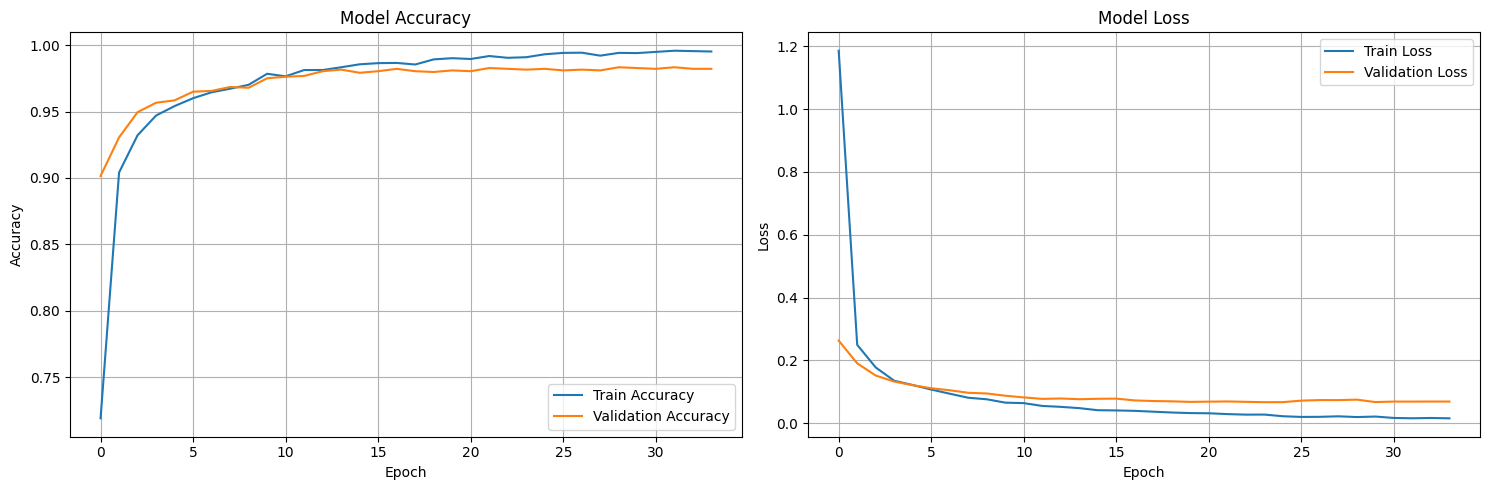

In [ ]:
# Eğitim grafiklerini çizdir
plot_history(history)

In [ ]:
# Test veri seti üzerinde değerlendirme
print("\nTest veri seti üzerinde değerlendirme yapılıyor...")
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



Test veri seti üzerinde değerlendirme yapılıyor...
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9875 - loss: 0.0373
Test Loss: 0.0484
Test Accuracy: 0.9834


In [ ]:
# Sınıflandırma raporu ve confusion matrix için tahminler
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=class_names))

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       glass       0.99      0.99      0.99      1010
       paper       0.99      1.00      0.99       540
     plastic       0.98      0.96      0.97       556

    accuracy                           0.98      2106
   macro avg       0.98      0.98      0.98      2106
weighted avg       0.98      0.98      0.98      2106




Confusion Matrix:


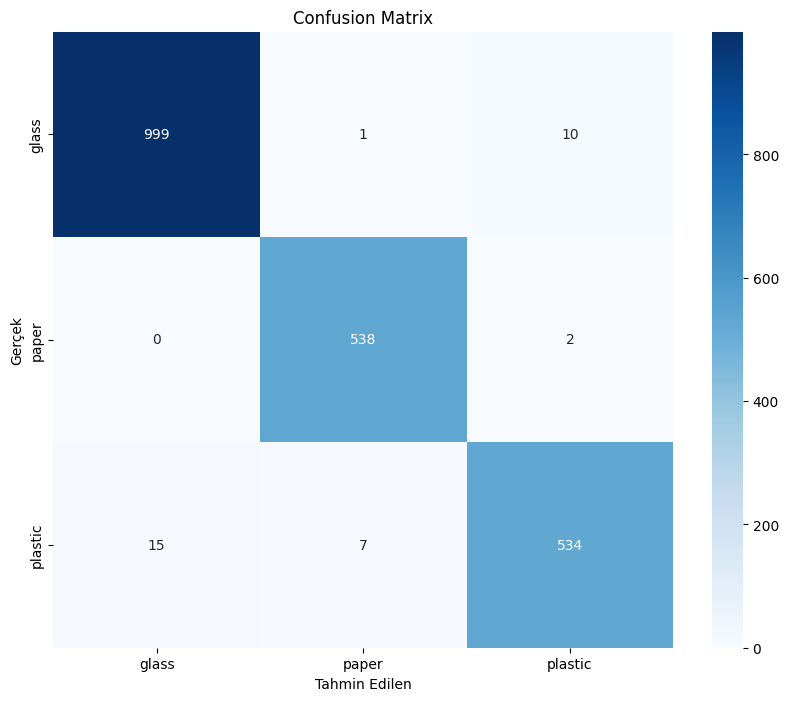

In [ ]:
# Confusion Matrix
print("\nConfusion Matrix:")
plot_confusion_matrix(y_true, y_pred, class_names)

In [ ]:
# İnce ayar (Fine-tuning) yapmak istiyorsanız
print("\nİnce ayar (Fine-tuning) yapılıyor...")


İnce ayar (Fine-tuning) yapılıyor...


In [ ]:
# ResNet101'in son 30 katmanını eğitilebilir yap
base_model = model.layers[1]
base_model.trainable = True

# Son 30 katmanı açalım, diğerleri donuk kalsın
for layer in base_model.layers[:-30]:
    layer.trainable = False


In [ ]:
# Daha düşük bir öğrenme oranı ile yeniden derle
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Daha düşük öğrenme oranı
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# İnce ayar eğitimi
print("İnce ayar eğitimi başlıyor...")
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,  # 100 epoch boyunca fine-tuning
    callbacks=[early_stopping, reduce_lr]
)

İnce ayar eğitimi başlıyor...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9940 - loss: 0.0213 - val_accuracy: 0.9834 - val_loss: 0.0696 - learning_rate: 1.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.9926 - loss: 0.0206 - val_accuracy: 0.9828 - val_loss: 0.0699 - learning_rate: 1.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.9939 - loss: 0.0170 - val_accuracy: 0.9828 - val_loss: 0.0708 - learning_rate: 1.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.9940 - loss: 0.0167 - val_accuracy: 0.9834 - val_loss: 0.0704 - learning_rate: 1.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.9946 - loss: 0.0175 - val_accuracy: 0.9834 - val_loss: 0.0713 - learning_rate: 1.0000e-04
Epoch 6/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9940 - loss: 0.0165
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
14/14 ━━━━━━━━━━━━━━━━━

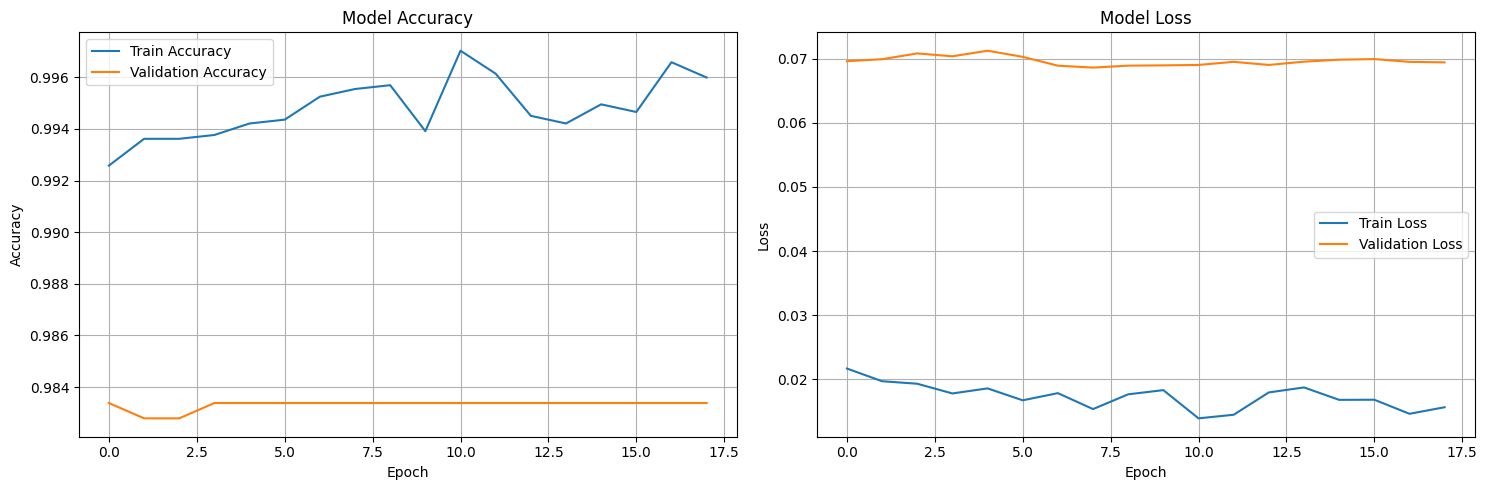

In [ ]:
# İnce ayar sonrası eğitim grafiklerini çizdir
plot_history(fine_tune_history)

In [ ]:
# İnce ayar sonrası test veri seti üzerinde değerlendirme
print("\nİnce ayar sonrası test veri seti üzerinde değerlendirme yapılıyor...")
fine_tune_test_loss, fine_tune_test_accuracy = model.evaluate(test_ds)
print(f"Fine-Tuning Sonrası Test Loss: {fine_tune_test_loss:.4f}")
print(f"Fine-Tuning Sonrası Test Accuracy: {fine_tune_test_accuracy:.4f}")


İnce ayar sonrası test veri seti üzerinde değerlendirme yapılıyor...
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 864ms/step - accuracy: 0.9901 - loss: 0.0320
Fine-Tuning Sonrası Test Loss: 0.0443
Fine-Tuning Sonrası Test Accuracy: 0.9862


In [ ]:
# İnce ayar sonrası sınıflandırma raporu ve confusion matrix için tahminler
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

# İnce ayar sonrası sınıflandırma raporu
print("\nİnce Ayar Sonrası Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=class_names))

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

İnce Ayar Sonrası Sınıflandırma Raporu:
              precision    recall  f1-score   support

       glass       0.99      0.99      0.99      1010
       paper       0.99      1.00      0.99       540
     plastic       0.98      0.97      0.97       556

    accuracy                           0.99      2106
   macro avg       0.99      0.98      0.99      2106
weighted avg       0.99      0.99      0.99      2106




İnce Ayar Sonrası Confusion Matrix:


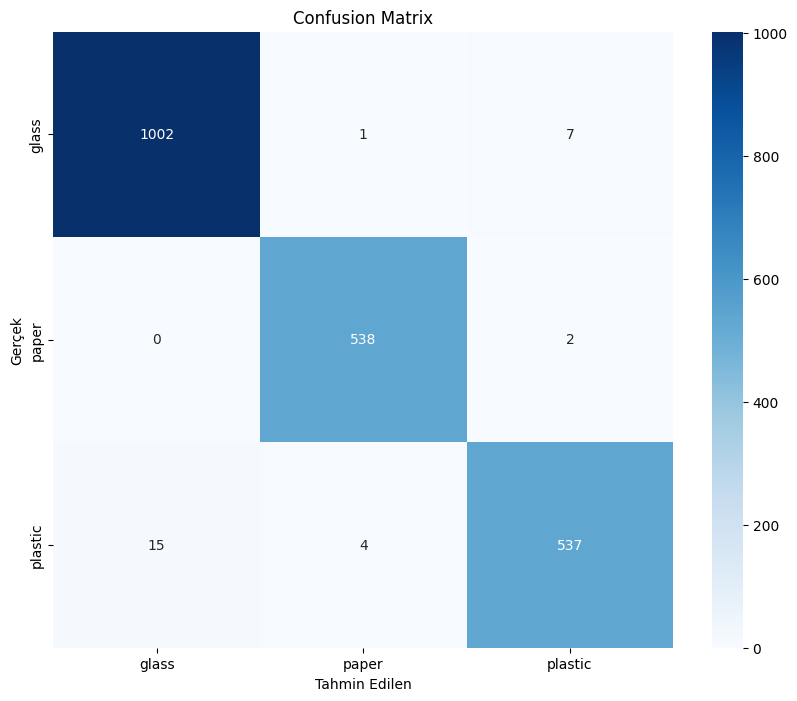

In [ ]:
# İnce ayar sonrası confusion matrix
print("\nİnce Ayar Sonrası Confusion Matrix:")
plot_confusion_matrix(y_true, y_pred, class_names)

In [ ]:
# Modeli kaydet
model.save("resnet101_model.h5")
print("\nModel kaydedildi: resnet101_modell.h5")


Model kaydedildi: resnet101_modell.h5


In [ ]:
# Fine-tuning sonrası eğitim grafiklerini çizdir - Tüm eğitimin birleştirilmiş grafiği
def plot_combined_history(initial_history, fine_tune_history):
    # Metrik isimlerini al
    acc = initial_history.history['accuracy']
    val_acc = initial_history.history['val_accuracy']
    loss = initial_history.history['loss']
    val_loss = initial_history.history['val_loss']

    # Fine-tuning metrikleri
    acc += fine_tune_history.history['accuracy']
    val_acc += fine_tune_history.history['val_accuracy']
    loss += fine_tune_history.history['loss']
    val_loss += fine_tune_history.history['val_loss']

    # İlk eğitim epochlarının sayısı
    initial_epochs = len(initial_history.history['accuracy'])
    total_epochs = len(acc)

    # x ekseni için epoch değerleri
    epochs_range = range(total_epochs)

    plt.figure(figsize=(15, 6))

    # Doğruluk grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Kayıp grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


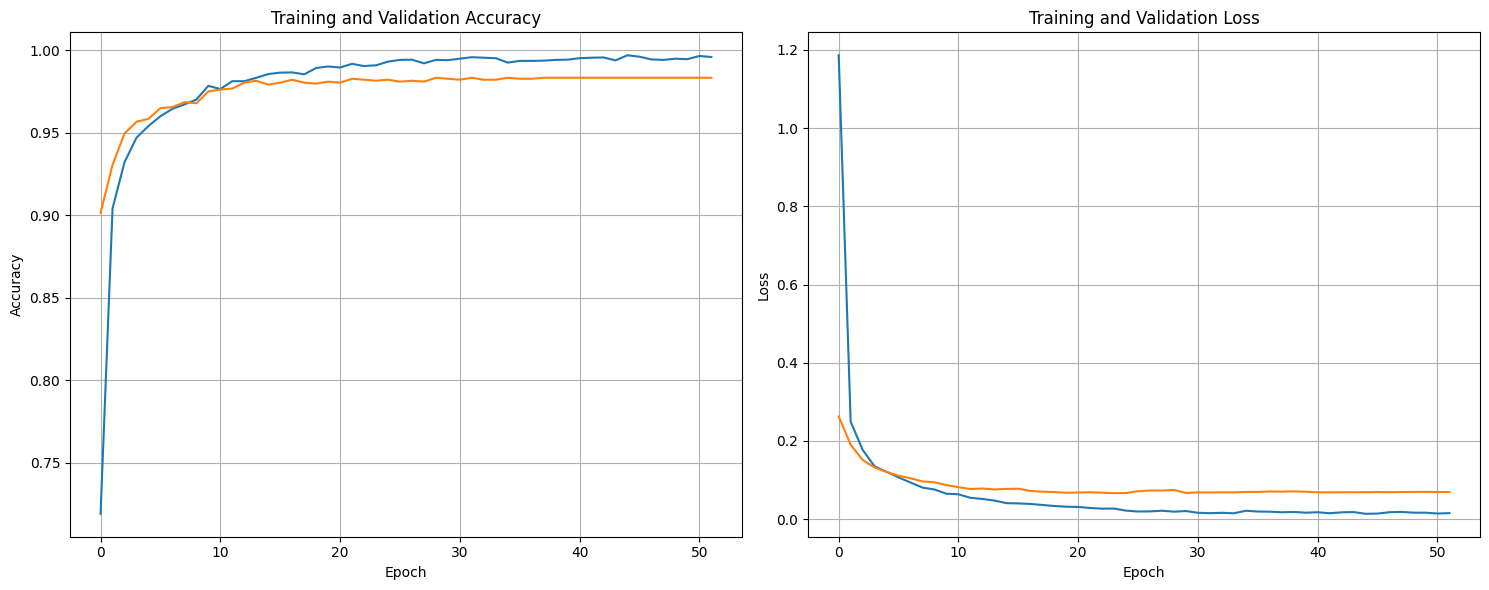

In [ ]:
# Tüm eğitimin birleştirilmiş grafiklerini çizdir

plot_combined_history(history, fine_tune_history)
